In [1]:
import os
import sys
import math
import logging
from typing import List, Dict, Tuple, Union, Any

import numpy as np
from scipy import stats
import statsmodels.api as sm

rgen = np.random.default_rng()

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)
lg = logging.getLogger('nb')

In [2]:
from censored_demand.simulate import *
from censored_demand.predict import *

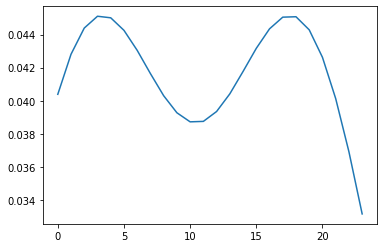

In [3]:
time_periods = 24
hour_peaks = [1.2, 8.8]

# First we make an interesting intraday demand curve
intraday_demand_curve = generate_intraday_demand_curve(time_periods=time_periods, peaks=hour_peaks)
plt.plot(intraday_demand_curve);

In [4]:
# Now we simulate where the mean of production and demand for each day are the same.
days = 2000
demand_mean = 100
demand_std=20
production_mean=demand_mean*0.9
production_std=demand_std
fixed_production=False
    
# Get simulated sales and waste
period_sales_daily, unsold_daily = generate_daily_period_sales(
    intraday_demand_curve,
    days=days,
    demand_mean=demand_mean,
    demand_std=demand_std,
    production_mean=production_mean,
    production_std=production_std,
    fixed_production=fixed_production)  

# Divide up days into fully known demand and stockout days
completed_days, stockout_days = split_days_by_stockout(period_sales_daily, unsold_daily)

# Find proportion of days where stockout ocurrs
proportion_of_stockout_days = stockout_days.shape[0]/period_sales_daily.shape[0]
print(f'Proportion of days experiencing product stockout: {proportion_of_stockout_days}')
waste_proportion= np.sum(unsold_daily)/np.sum(period_sales_daily)
print(f'Waste percentage: {waste_proportion*100}')

# Train models for each number of known demand periods
period_models = create_models_by_known_periods(completed_days)
pred_stockout_demands = predict_stockout_daily_demand(stockout_days, period_models)

# Drop cases where no periods were known
pred_stockout_demands = pred_stockout_demands[~np.isnan(pred_stockout_demands)]
completed_demands = np.sum(completed_days, axis=1)

# Combine predicted and known daily demands
combined_demands = np.hstack([pred_stockout_demands, completed_demands])

# Estimate production level at which 90% of days will no have stockout
upper_limit_90_demand = stats.norm.ppf(0.9, loc=np.mean(combined_demands), scale=np.std(combined_demands))
predicted_demand_mean = np.mean(combined_demands)
print(f'mean: {np.mean(combined_demands)} upper_limit_90: {upper_limit_90_demand}')

Proportion of days experiencing product stockout: 0.6435
Waste percentage: 8.96116363282864
mean: 99.60182322656983 upper_limit_90: 128.3218478207333


In [5]:
# if we try fixing the production at the estimated value where production exceeds demand 90% of the time
# We see waste goes up, but stockout days goes to ~10%
days = 2000
demand_mean = 100
demand_std=20
production_mean=upper_limit_90_demand
fixed_production=True
    
# Get simulated sales and waste
period_sales_daily, unsold_daily = generate_daily_period_sales(
    intraday_demand_curve,
    days=days,
    demand_mean=demand_mean,
    demand_std=demand_std,
    production_mean=production_mean,
    production_std=demand_std,
    fixed_production=fixed_production)  

# Divide up days into fully known demand and stockout days
completed_days, stockout_days = split_days_by_stockout(period_sales_daily, unsold_daily)

# Find proportion of days where stockout ocurrs
proportion_of_stockout_days = stockout_days.shape[0]/period_sales_daily.shape[0]
print(f'Proportion of days experiencing product stockout: {proportion_of_stockout_days}')
waste_proportion= np.sum(unsold_daily)/np.sum(period_sales_daily)
print(f'Waste percentage: {waste_proportion*100}')

Proportion of days experiencing product stockout: 0.109
Waste percentage: 29.742440982393546


In [6]:
# Waste pct is a dependent on the pct of stockout days acceptable, and the standard deviation of the demand.
# a lower standard deviation of demand allows for lower waste at the same stockout proportion.

# let's analyze to find the optimal prodution level to maximize profit
days = 2000
production_levels = np.arange(0.5,1.5,0.1)
demand_mean = predicted_demand_mean
demand_std = 20
markup = 0.5

profits = []
waste_proportions = []
proportion_stockouts = []
for level in production_levels:
    # Get simulated sales and waste
    period_sales_daily, unsold_daily = generate_daily_period_sales(
        intraday_demand_curve,
        days=days,
        demand_mean=demand_mean,
        demand_std=demand_std,
        production_mean=demand_mean*level,
        production_std=demand_std,
        fixed_production=True
    )

    # Divide up days into fully known demand and stockout days
    completed_days, stockout_days = split_days_by_stockout(period_sales_daily, unsold_daily)

    # Find proportion of days where stockout ocurrs
    proportion_of_stockout_days = stockout_days.shape[0]/period_sales_daily.shape[0]
    proportion_stockouts.append(proportion_of_stockout_days)
    
    # Find waste proportion
    waste_proportion= np.sum(unsold_daily)/np.sum(period_sales_daily)
    waste_proportions.append(waste_proportion)
    profit = np.sum(period_sales_daily)*(1+markup) - (demand_mean*level*days)
    profits.append(profit)

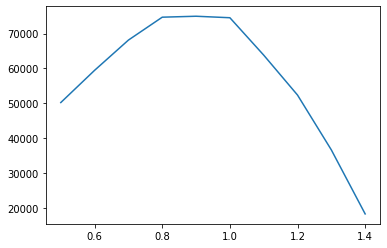

In [7]:
# Let's plot the profits at different proportions of the predicted_demand_mean
plt.plot(production_levels, profits);

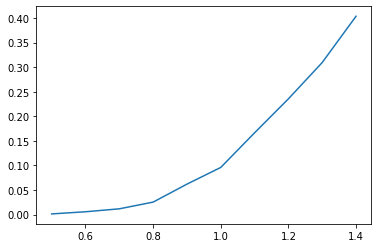

In [8]:
# Next we look at the % of waste 
plt.plot(production_levels, waste_proportions);

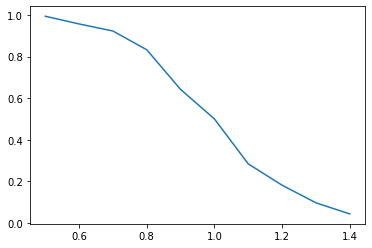

In [9]:
# Finally, let's look at the proportion of stockouts at each production level
plt.plot(production_levels, proportion_stockouts);

It looks like in this case the optimal profit level is at ~90% of the mean demand, where stockouts occcur about 65% of the time.